# Modelo de detección automática de críticas negativas en Film Junky Union por *Carlos Horta* (carlosgim@gmail.com)

# Descripcipción del proyecto

Film Junky Union, una nueva comunidad vanguardista para los aficionados de las películas clásicas, está desarrollando un sistema para filtrar y categorizar reseñas de películas. Tu objetivo es entrenar un modelo para detectar las críticas negativas de forma automática. Para lograrlo, utilizarás un conjunto de datos de reseñas de películas de IMDB con leyendas de polaridad para construir un modelo para clasificar las reseñas positivas y negativas. Este deberá alcanzar un valor F1 de al menos 0.85.

## Inicialización

In [1]:
import sys
import warnings

# Ignorar las advertencias
if not sys.warnoptions:
    warnings.simplefilter("ignore")

import math
import numpy as np
import pandas as pd
import plotly.express as px

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import sklearn.metrics as metrics
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV

import re
import spacy
import nltk

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import torch
import transformers

from tqdm.auto import tqdm

# Descargar los stopwords de NLTK
nltk.download('stopwords')

# Inicializar el lematizador y el modelo de procesamiento de texto de Spacy
lemmatizer = WordNetLemmatizer()
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Configuración para los gráficos
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Establecer el estilo de los gráficos
plt.style.use('seaborn')

# Configuración para mostrar el progreso durante las iteraciones
tqdm.pandas()

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Cargar datos

In [2]:
# Se cargan los datos del fichero csv en los dataframes correspondientes

try: 
    df_reviews = pd.read_csv('imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})
except:
    df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [3]:
# Se revisa el contenido del dataframe

df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [4]:
df_reviews.sample(5)

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
32842,tt0427688,movie,Studio 666,Studio 666,2005,\N,76,0,"Horror,Music,Sci-Fi",2.9,350,"As with most of the reviewers, I saw this on S...",3,neg,0,train,2791
16814,tt0119305,movie,Homegrown,Homegrown,1998,\N,102,0,"Comedy,Crime,Drama",5.8,4439,A fun romp...a lot of good twists and turns! (...,8,pos,1,test,11768
17623,tt0079322,movie,I... For Icarus,I... comme Icare,1979,\N,120,0,"Crime,Drama,Mystery",7.9,3449,I'm not tired to say this is one of the best p...,9,pos,1,train,9489
40311,tt0063374,movie,The Odd Couple,The Odd Couple,1968,\N,105,0,Comedy,7.7,30606,Some of the best movies that are categorized a...,10,pos,1,train,11544
28057,tt0780595,movie,Redline,Redline,2007,\N,95,0,Action,4.0,8493,This movie was bad to say the least!!! The ple...,1,neg,0,train,7127


In [5]:
# Con describe se obtiene un resumen estadístico de los datos

df_reviews.describe()

,start_year,is_adult,average_rating,votes,rating,pos,idx
count,47331.000000,47331.000000,47329.000000,4.732900e+04,47331.000000,47331.000000,47331.000000
mean,1989.631235,0.001732,5.998278,2.556292e+04,5.484608,0.498954,6279.697999
std,19.600364,0.041587,1.494289,8.367004e+04,3.473109,0.500004,3605.702545
min,1894.000000,0.000000,1.400000,9.000000e+00,1.000000,0.000000,0.000000
25%,1982.000000,0.000000,5.100000,8.270000e+02,2.000000,0.000000,3162.000000
50%,1998.000000,0.000000,6.300000,3.197000e+03,4.000000,0.000000,6299.000000
75%,2004.000000,0.000000,7.100000,1.397400e+04,9.000000,1.000000,9412.000000
max,2010.000000,1.000000,9.700000,1.739448e+06,10.000000,1.000000,12499.000000


El proyecto se centra en un conjunto de datos que contiene reseñas de películas. Algunas columnas relevantes en el conjunto de datos son:

- `review`: el texto de la reseña.
- `pos`: es la columna objetivo, donde si el valor es '0', la reseña se considera negativa, y si es '1', se considera positiva.
- `ds_part`: indica si la fila es para entrenamiento o prueba.

Además de estas columnas, también se incluyen otras características de las películas, como:

- `title_type`: el tipo de película.
- `original_title`: el título original de la película.
- `primary_title`: el título en inglés de la película.
- `start_year`: el año de lanzamiento de la película.
- `runtime_minutes`: la duración en minutos de la película.
- `adult`: indica si la película es para adultos (si el valor es '0', no es para adultos).
- `average_rating`: la calificación promedio de la película.
- `votes`: el número de votos recibidos por la película.

## Análisis Exploratorio de Datos (EDA)

Veamos el número de películas y reseñas a lo largo de los años.

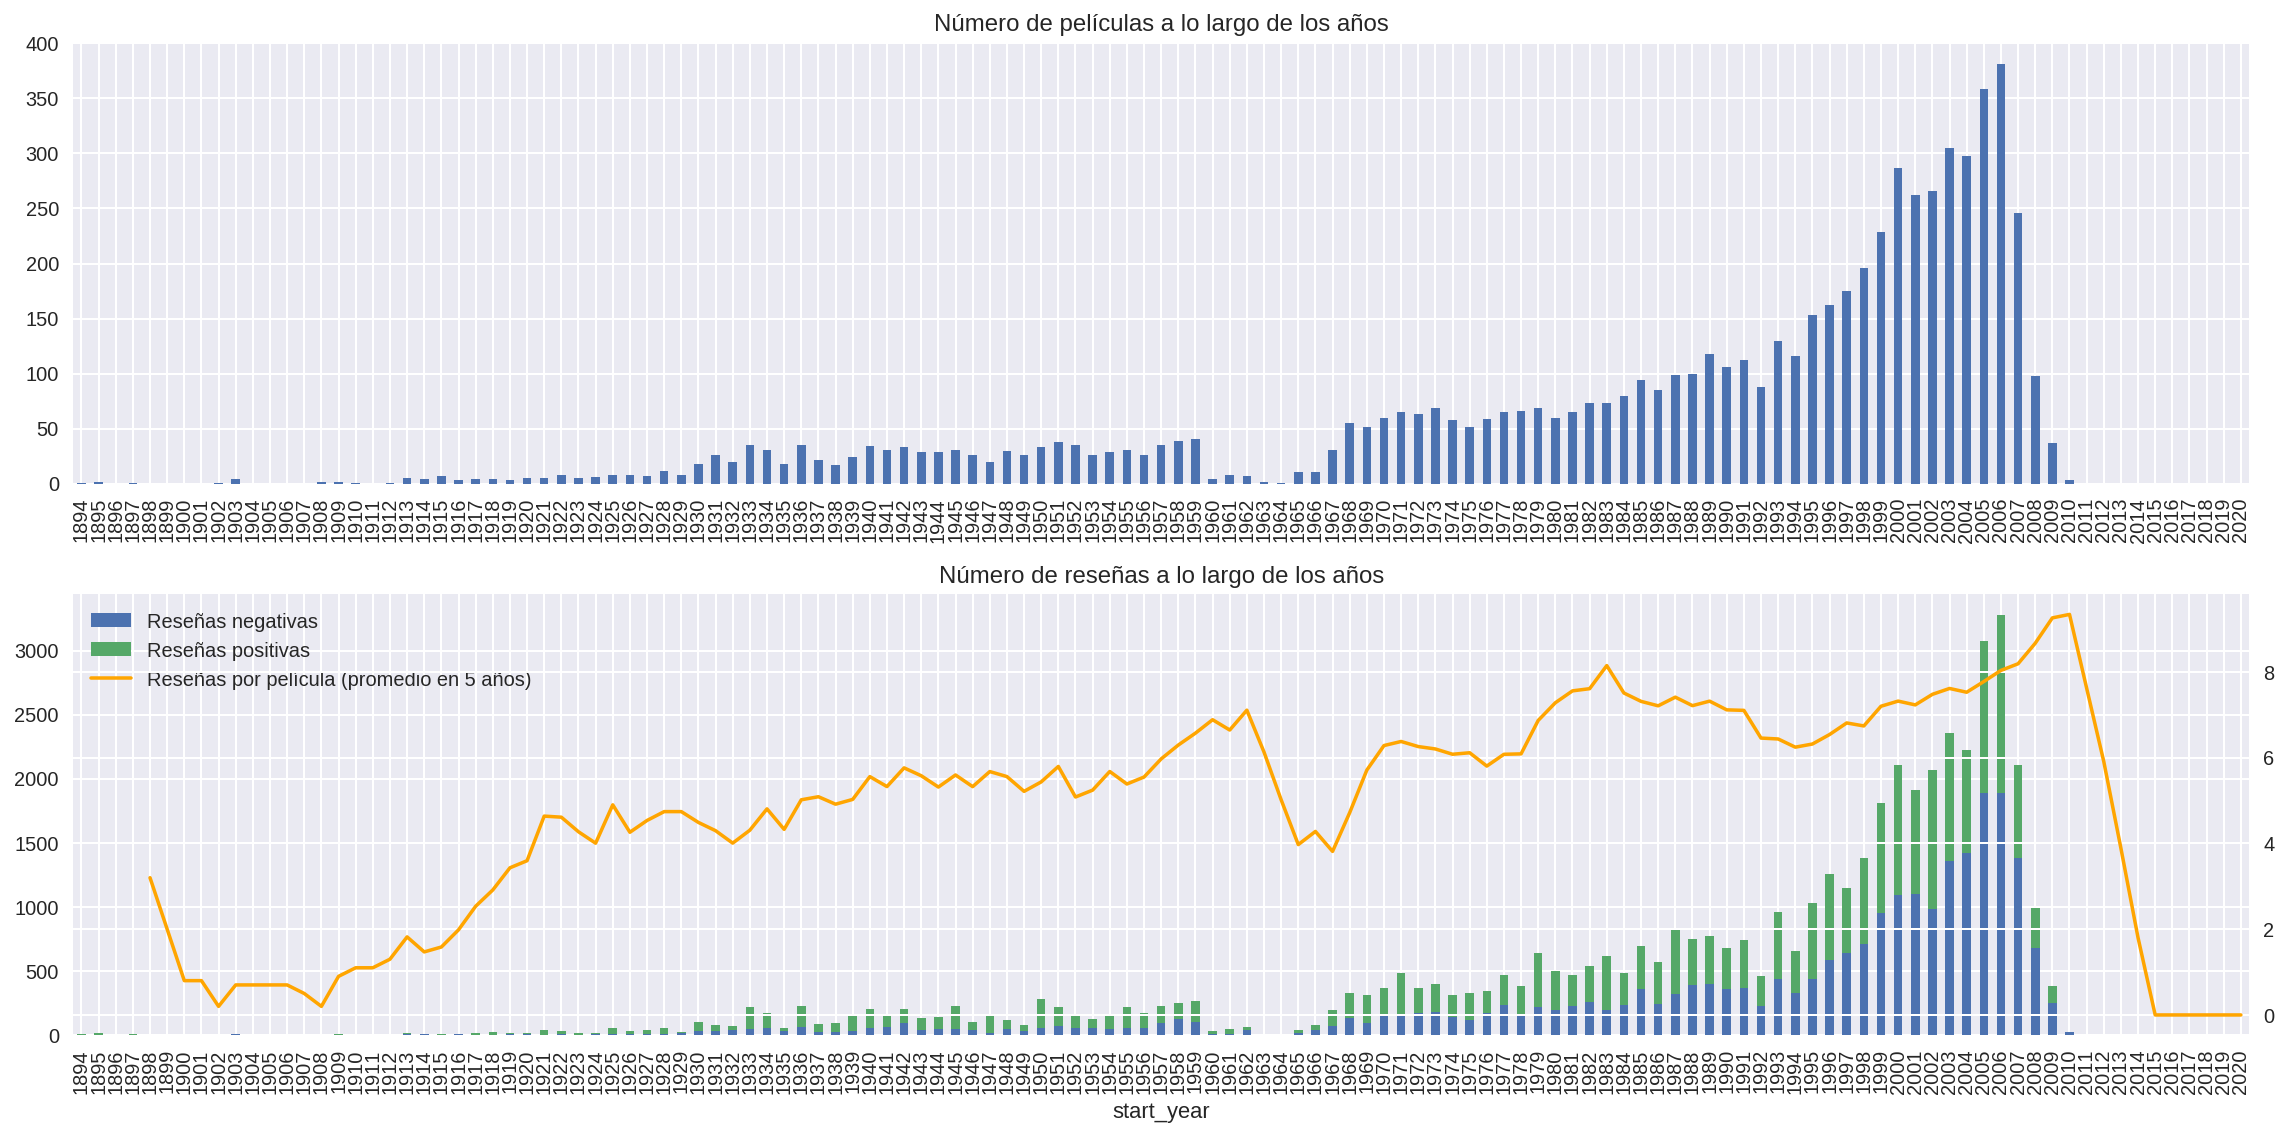

In [6]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]
dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates()['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de películas a lo largo de los años')

ax = axs[1]
dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft2.columns = ['Reseñas negativas', 'Reseñas positivas'] 
dft2.plot(kind='bar', stacked=True, ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2 / dft1).fillna(0)

axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='Reseñas por película (promedio en 5 años)', ax=axt)

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = axt.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc='upper left')

ax.set_title('Número de reseñas a lo largo de los años')

fig.tight_layout()
plt.show()


Al analizar los datos, se puede observar que la distribución de películas y reseñas a lo largo de los años presenta una asimetría negativa. Esto significa que hay más valores que se desvían hacia la izquierda de la media que hacia la derecha. En otras palabras, hay una concentración de películas y reseñas en los años anteriores a la media.

En particular, se identifica que el año con el mayor número de películas fue en 2006, lo que indica un punto alto en la producción cinematográfica. Por otro lado, al considerar un promedio de cinco años, se nota que la cantidad de reseñas por película ha experimentado un incremento a lo largo del tiempo. Esto sugiere un mayor interés y participación del público en el proceso de reseñar películas en períodos más recientes.

Veamos la distribución del número de reseñas por película con el conteo exacto y KDE (solo para saber cómo puede diferir del conteo exacto)

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de barras de #Reseñas por película')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico KDE de #Reseñas por película')

fig.tight_layout()

La distribución de reseñas por película muestra un patrón en el que la mayoría de las películas tienen pocas reseñas, mientras que un número reducido de películas acumula un mayor número de reseñas. Esta tendencia se evidencia al observar que más de 1200 películas recibieron solo una reseña, y alrededor de 1000 películas recibieron únicamente dos reseñas. A medida que aumenta el número de reseñas, este patrón se mantiene, aunque aproximadamente 400 películas llegaron a registrar hasta 30 reseñas.

Al analizar el gráfico de distribución de densidades, se confirma este comportamiento. La densidad de frecuencia más alta, que se sitúa alrededor de 0.12, se observa en el rango de 0 a 5 reseñas. Posteriormente, se presenta otro pico alrededor de las 30 reseñas por película.

Este fenómeno revela que la mayoría de las películas tienen una cantidad limitada de reseñas, lo cual podría indicar una menor visibilidad o interés por parte del público. Sin embargo, la presencia de al menos 400 películas con 30 reseñas sugiere que estas podrían ser grandes éxitos o producciones destacadas que han generado un mayor impacto y atracción de audiencia.

En la siguiente etapa, se realizará un análisis del número de reseñas positivas y negativas por película para determinar si existe un desbalance de clases en los datos. Esto permitirá evaluar si el conjunto de datos está equilibrado en términos de opiniones positivas y negativas.

In [ ]:
# Con este código se obtiene el número de reseñas negativas y positivas por película

df_reviews['pos'].value_counts()

En el análisis de las reseñas, se ha observado que el número de reseñas positivas y negativas es similar, lo que indica un equilibrio entre las clases. Esto significa que no es necesario realizar un proceso de equilibrado de clases para el modelo o el análisis posterior.

Al contar con un número similar de reseñas positivas y negativas, se tiene una distribución más balanceada de los datos, lo que puede mejorar la capacidad del modelo para aprender y generalizar correctamente. Además, evita un sesgo hacia una clase particular y ayuda a obtener resultados más confiables y representativos. Este equilibrio en las clases también es beneficioso al realizar análisis posteriores, como la comparación de sentimientos entre diferentes películas o la identificación de patrones de opinión.

En resumen, al tener un número similar de reseñas positivas y negativas, no es necesario equilibrar las clases, lo que proporciona una base sólida para realizar un análisis más preciso y confiable de las reseñas de películas.

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de entrenamiento: distribución de puntuaciones')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('El conjunto de prueba: distribución de puntuaciones')

fig.tight_layout()

Como se observa en ambos gráficos anteriores, la distribución de las puntuaciones en los conjuntos de entrenamiento y de prueba es similar. Esto indica que las muestras utilizadas y las conclusiones obtenidas serán objetivas y precisas.

Al tener una distribución similar de las puntuaciones en ambos conjuntos, se reduce la posibilidad de sesgos o discrepancias significativas entre ellos. Esto brinda mayor confiabilidad a las conclusiones extraídas del análisis y permite generalizar de manera más precisa los resultados a datos no vistos previamente.

La similitud en la distribución de las puntuaciones entre el conjunto de entrenamiento y el de prueba es un indicador positivo de la calidad del modelo y su capacidad para generalizar de manera efectiva. Además, proporciona una base sólida para la toma de decisiones basada en los resultados del análisis.

En resumen, al observar la similitud en la distribución de las puntuaciones en ambos conjuntos de datos, podemos afirmar que las muestras utilizadas y las conclusiones obtenidas serán objetivas y precisas, brindando una mayor confiabilidad a los resultados del análisis.


Distribución de reseñas negativas y positivas a lo largo de los años para dos partes del conjunto de datos

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de entrenamiento: número de reseñas de diferentes polaridades por año')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.histplot(dft[0], color='blue', label='negative', kde=True, ax=ax)
sns.histplot(dft[1], color='green', label='positive', kde=True, ax=ax)
ax.legend()
ax.set_title('El conjunto de entrenamiento: distribución de diferentes polaridades por película')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('El conjunto de prueba: número de reseñas de diferentes polaridades por año')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.histplot(dft[0], color='blue', label='negative', kde=True, ax=ax)
sns.histplot(dft[1], color='green', label='positive', kde=True, ax=ax)
ax.legend()
ax.set_title('El conjunto de prueba: distribución de diferentes polaridades por película')

fig.tight_layout()


## Conclusiones del Análisis Exploratorio de Datos

Como se puede observar en los gráficos anteriores, las diferencias entre ambos conjuntos de datos son mínimas y poco notorias. Esto indica que se mantiene la similitud en la distribución de las variables analizadas.

La consistencia en la distribución entre el conjunto de entrenamiento y el conjunto de prueba es un aspecto positivo, ya que respalda la generalización de los resultados y conclusiones obtenidos. Esta similitud sugiere que el modelo entrenado con el conjunto de entrenamiento será capaz de aplicar su conocimiento y obtener resultados confiables en el conjunto de prueba.

Al mantener la similitud en la distribución, se minimiza la posibilidad de que existan sesgos o discrepancias significativas entre los conjuntos, lo que proporciona una base sólida para realizar inferencias y conclusiones válidas en el contexto del análisis de datos.

En resumen, los gráficos demuestran que las diferencias entre los conjuntos de datos son mínimas y poco notorias, lo que respalda la similitud en su distribución. Esto garantiza la consistencia en los resultados y brinda confianza en la generalización de los análisis realizados.

## Procedimiento de evaluación

Este proyecto tiene como objetivo entrenar un modelo capaz de detectar de manera automática las críticas negativas en reseñas de películas. Para lograrlo, se utilizará un conjunto de datos de reseñas de películas previamente etiquetadas como positivas o negativas. El objetivo es construir un modelo que pueda clasificar las reseñas en estas dos categorías.

La métrica de evaluación seleccionada para medir el desempeño del modelo es el valor F1, que combina la precisión y el recall del modelo en una única medida. El objetivo es alcanzar un valor F1 de al menos 0.85, lo que indicaría un buen equilibrio entre la capacidad del modelo para identificar las críticas negativas y clasificarlas correctamente.

Al lograr este objetivo, se podrá contar con un modelo confiable y preciso que pueda ser utilizado en la comunidad Film Junky Union para filtrar y categorizar las reseñas de películas de manera automatizada, proporcionando así una experiencia más enriquecedora y eficiente para los aficionados a las películas clásicas.

In [ ]:
def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # establecer cruces para algunos umbrales        
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalización

El siguiente paso consiste en la construcción de modelos predictivos. Se parte del supuesto de que todos los modelos a continuación requieren que los textos estén en minúsculas y sin dígitos, signos de puntuación, entre otros. Para lograr esto, se utilizará la función 'clear_text', la cual se aplicará a la columna 'review' del conjunto de datos. Esta función permitirá normalizar el texto de cada crítica, eliminando elementos no deseados como dígitos y signos de puntuación.

Al aplicar la función 'clear_text', se asegurará que los textos estén en un formato consistente y limpio, lo cual es fundamental para obtener resultados precisos y confiables al momento de entrenar y evaluar los modelos predictivos. De esta manera, se preparará adecuadamente el conjunto de datos para su posterior procesamiento y entrenamiento de los modelos de clasificación de críticas.

In [ ]:
def clear_text(text):
    clean_text = re.sub(r"[^a-zA-Z]", ' ', text)
    clean_text = " ".join(word_tokenize(clean_text))
    return clean_text.lower()

In [ ]:
pd.set_option('display.max_colwidth', 100)


df_reviews['review_norm']= df_reviews['review'].apply(clear_text)

df_reviews['review_norm'].head()

## División entrenamiento / prueba

Afortunadamente, el conjunto de datos ya ha sido dividido previamente en conjuntos de entrenamiento y prueba, y esta información se encuentra disponible en el indicador 'ds_part'.

Esta división en conjuntos de entrenamiento y prueba es esencial para evaluar la capacidad de generalización del modelo. Utilizando el conjunto de entrenamiento, el modelo aprenderá los patrones y características de las críticas de películas. Luego, se utilizará el conjunto de prueba para evaluar qué tan bien el modelo puede clasificar las críticas de películas no vistas durante el entrenamiento.

Gracias a esta división preexistente, podemos proceder directamente con la etapa de entrenamiento y evaluación de los modelos utilizando los conjuntos de datos correspondientes a los indicadores 'ds_part' de entrenamiento y prueba.

In [ ]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

train_features = df_reviews_train['review_norm']
test_features = df_reviews_test['review_norm']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

## Trabajar con modelos

Con nuestros conjuntos de entrenamiento y prueba ya establecidos, procederemos a entrenar modelos de aprendizaje automático para el procesamiento de texto. En este caso, utilizaremos tres técnicas de preprocesamiento: NLTK, spaCy y BERT. Aplicaremos estas técnicas a diversos modelos de regresión logística y potenciación de gradiente.

Una vez entrenados los modelos, evaluaremos su rendimiento utilizando la métrica del valor F1 mediante la función "evaluate_model". En este proyecto, el objetivo será alcanzar un valor F1 de al menos 0.85. Esto nos permitirá tener una medida cuantitativa del desempeño de cada modelo en la clasificación de las reseñas de películas.

A través de esta evaluación exhaustiva, podremos determinar qué combinación de técnicas de preprocesamiento y modelos de aprendizaje automático produce los mejores resultados en términos de clasificación de las reseñas de películas. Esto nos permitirá seleccionar el modelo más eficiente y efectivo para detectar y clasificar automáticamente las críticas negativas en nuestro proyecto.

### Modelo 0 - Constante

Comenzaremos realizando una prueba de cordura utilizando un modelo DummyClassifier. Para esto, utilizaremos las revisiones lematizadas, donde cada palabra se reduce a su raíz. 

Para el modelo DummyClassifier, utilizaremos la estrategia "constant" que siempre predicirá la clase positiva. Esta elección se basa en el hecho de que la precisión y la sensibilidad se basan en la proporción de verdaderos positivos.

Esta prueba nos permitirá establecer un punto de referencia inicial y evaluar cómo se desempeñan los modelos más sofisticados en comparación con un modelo simple y sin aprendizaje. A partir de los resultados obtenidos, podremos analizar la efectividad de los modelos más complejos y determinar si logran superar o no el rendimiento del DummyClassifier en la clasificación de las críticas normalizadas.

In [ ]:
dummy = DummyClassifier(strategy='most_frequent').fit(train_features, train_target) 

In [ ]:
evaluate_model(dummy, train_features, train_target, test_features, test_target)

Las gráficas anteriores representan la línea base de referencia, que servirá como punto de comparación para evaluar los tres modelos que se desarrollarán a continuación.

Estas visualizaciones proporcionan una perspectiva inicial sobre las características y patrones presentes en los datos. Al establecer la línea base, podemos identificar y contrastar los resultados y mejoras logrados por los modelos posteriores.

La línea base de referencia es esencial para evaluar el rendimiento y la efectividad de los modelos desarrollados. Nos permite medir el progreso realizado y determinar si los nuevos modelos logran una mejora significativa en comparación con la línea base establecida.

A partir de ahora, nos centraremos en los tres modelos específicos que se desarrollarán, utilizando la línea base como punto de referencia para comparar su rendimiento y evaluar su capacidad para proporcionar resultados superiores.

### Modelo 1 - NLTK, TF-IDF y LR

En este modelo, utilizaremos la técnica TF-IDF (Frecuencia de Término - Frecuencia Inversa de Documento) de la librería NLTK para predecir el sentimiento de las reseñas.

TF-IDF se basa en la importancia de cada palabra en una crítica, determinada por el valor de TF-IDF. TF (Frecuencia de Término) representa la frecuencia con la que una palabra aparece en un texto, mientras que IDF (Frecuencia Inversa de Documento) mide la frecuencia de aparición de la palabra en el corpus en general.

Además, eliminaremos aquellas palabras que por sí solas no aportan peso al sentimiento de la reseña, es decir, las denominadas "stop words" o palabras de parada. Estas palabras son comunes y no aportan información relevante para la clasificación del sentimiento.

Al utilizar TF-IDF junto con la eliminación de stop words, podremos resaltar las palabras más importantes y descriptivas de las reseñas, lo que ayudará a nuestro modelo a capturar mejor los patrones y características relevantes para predecir el sentimiento de las reseñas de películas.

In [ ]:
train_corpus = []
test_corpus = []

# Corpus de entrenamiento
for text in df_reviews_train['review_norm']:
    tokens = word_tokenize(text)
    lemmas = [lemmatizer.lemmatize(t) for t in tokens]
    l_join = " ".join(lemmas)
    train_corpus.append(l_join)

# Corpus de prueba
for text in df_reviews_test['review_norm']:
    tokens = word_tokenize(text)
    lemmas = [lemmatizer.lemmatize(t) for t in tokens]
    l_join = " ".join(lemmas)
    test_corpus.append(l_join)

In [ ]:
# Vectorización del corpus con TF-IDF Vectorizer y palabras de parada
vectorizer_mod1 = TfidfVectorizer(stop_words=stopwords.words('english'), lowercase=True)
train_features_mod1 = vectorizer_mod1.fit_transform(train_corpus)
test_features_mod1 = vectorizer_mod1.transform(test_corpus)

In [ ]:
# Modelo de regresión logística
model_1 = LogisticRegression(random_state=1984, max_iter=100)

# Ajuste del modelo
model_1.fit(train_features_mod1, train_target)

In [ ]:
# Evaluación del modelo 1 de regresión logística con NLTK
evaluate_model(model_1, train_features_mod1, train_target, test_features_mod1, test_target)

A partir de los resultados obtenidos en la evaluación del modelo de regresión logística con NLTK, podemos concluir lo siguiente:

- El modelo muestra un desempeño sobresaliente en la clasificación de sentimientos tanto en el conjunto de entrenamiento como en el conjunto de prueba. Con un valor de F1 de **0.94** en el conjunto de entrenamiento y **0.88** en el conjunto de prueba, demuestra una alta precisión en la predicción de las críticas negativas.

- Las métricas de precisión promedio por clase (APS) también son altas, con un valor de **0.98** en el conjunto de entrenamiento y **0.95** en el conjunto de prueba. Esto indica que el modelo tiene una alta capacidad para identificar correctamente tanto las críticas positivas como las negativas.

- El área bajo la curva ROC (ROC AUC) también refleja un rendimiento excepcional, con un valor de **0.98** en el conjunto de entrenamiento y **0.95** en el conjunto de prueba. Esto sugiere que el modelo tiene una alta capacidad para distinguir entre las clases positivas y negativas.

En general, el modelo de regresión logística con NLTK demuestra una excelente capacidad para clasificar las críticas de películas en sentimientos positivos y negativos. Los resultados obtenidos cumplen con el objetivo establecido de alcanzar un valor de F1 de al menos 0.85, lo que indica que el modelo es confiable y preciso en su capacidad de detección de críticas negativas.

Resultados del modelo de regresión logística con NLTK:

Conjunto de entrenamiento:
- Exactitud (Accuracy): 0.94
- F1: 0.94
- APS (Promedio de Precisión y Sensibilidad): 0.98
- ROC AUC (Área bajo la curva ROC): 0.98

Conjunto de prueba:
- Exactitud (Accuracy): 0.88
- F1: 0.88
- APS (Promedio de Precisión y Sensibilidad): 0.95
- ROC AUC (Área bajo la curva ROC): 0.95


### Modelo 2 - spaCy, TF-IDF y LR

El siguiente modelo que vamos a entrenar es el Modelo 2, el cual utiliza la librería spaCy junto con TF-IDF (Frecuencia de Término - Frecuencia Inversa de Documento) y una regresión logística (LR).

En este modelo, utilizaremos spaCy para realizar el procesamiento de texto, incluyendo la tokenización, lematización y eliminación de palabras irrelevantes. Luego, aplicaremos la técnica TF-IDF para calcular la importancia de cada palabra en cada crítica.

A continuación, entrenaremos un modelo de regresión logística (LR) utilizando las características obtenidas con TF-IDF. La regresión logística es un algoritmo de aprendizaje automático supervisado que nos permite clasificar las críticas de películas como positivas o negativas.

Este modelo nos permitirá evaluar cómo el uso de spaCy en combinación con TF-IDF y LR puede mejorar la capacidad de clasificación de sentimientos en comparación con otros modelos anteriores. Una vez entrenado, evaluaremos su rendimiento utilizando las métricas adecuadas.

In [ ]:
# Función para el procesamiento de texto

def text_preprocessing_2(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc if not token.is_stop]
    
    return ' '.join(tokens)

In [ ]:
# Obtención del corpus para cada conjunto utilizando 'text_preprocessing_2'
train_corpus2 = []
test_corpus2  = []

# Corpus de entrenamiento
for text in df_reviews_train['review_norm']:
    result=text_preprocessing_2(text)
    train_corpus2.append(result)

# Corpus de prueba
for text in df_reviews_test['review_norm']:
    result=text_preprocessing_2(text)
    test_corpus2.append(result)

In [ ]:
# Vectorización del corpus con TF-IDF Vectorizer y palabras de parada
vectorizer_mod2 = TfidfVectorizer(stop_words=stopwords.words('english'), lowercase=True)
train_features_mod2 = vectorizer_mod2.fit_transform(train_corpus2)
test_features_mod2  = vectorizer_mod2.transform(test_corpus2)

In [ ]:
# Regresión logística
model_2 = LogisticRegression(random_state=1984, max_iter=100)

# Ajuste del modelo
model_2.fit(train_features_mod2, train_target)

In [ ]:
# Evaluación del modelo 2 de regresión logística con spaCy
evaluate_model(model_2, train_features_mod2, train_target, test_features_mod2, test_target)

A partir de los resultados obtenidos en la evaluación del Modelo 2, que utiliza spaCy para el procesamiento de texto, TF-IDF para la representación de características y regresión logística (LR) como algoritmo de clasificación, podemos concluir lo siguiente:

- El modelo muestra un desempeño sólido en la clasificación de sentimientos tanto en el conjunto de entrenamiento como en el conjunto de prueba. Tanto el conjunto de entrenamiento como el conjunto de prueba tienen una exactitud (accuracy) de **0.93** y **0.87**, respectivamente. Esto indica que el modelo logra una alta tasa de clasificación correcta en ambos conjuntos.

- El valor de F1 obtenido es de **0.93** en el conjunto de entrenamiento y **0.87** en el conjunto de prueba. Esto muestra una buena combinación de precisión y exhaustividad en la clasificación de sentimientos positivos y negativos.

- Las métricas de precisión promedio por clase (APS) son altas, con un valor de **0.98** en el conjunto de entrenamiento y **0.94** en el conjunto de prueba. Esto demuestra que el modelo tiene una alta capacidad para identificar correctamente tanto las críticas positivas como las negativas.

- El área bajo la curva ROC (ROC AUC) también refleja un rendimiento sólido, con un valor de **0.98** en el conjunto de entrenamiento y **0.95** en el conjunto de prueba. Esto sugiere que el modelo tiene una buena capacidad para distinguir entre las clases positivas y negativas.

En general, el Modelo 2 - spaCy, TF-IDF y LR demuestra un buen desempeño en la clasificación de sentimientos de las críticas de películas. Los resultados obtenidos muestran una alta precisión y capacidad para identificar correctamente los sentimientos positivos y negativos en los conjuntos de entrenamiento y prueba.

Resultados del Modelo 2 - spaCy, TF-IDF y LR:

Conjunto de entrenamiento:
- Exactitud (Accuracy): 0.93
- F1: 0.93
- APS (Promedio de Precisión y Sensibilidad): 0.98
- ROC AUC (Área bajo la curva ROC): 0.98

Conjunto de prueba:
- Exactitud (Accuracy): 0.87
- F1: 0.87
- APS (Promedio de Precisión y Sensibilidad): 0.94
- ROC AUC (Área bajo la curva ROC): 0.95


### Modelo 3 - spaCy, TF-IDF y LGBMClassifier

In [ ]:
train_features_mod3 = train_features_mod2
test_features_mod3  = test_features_mod2

In [ ]:
model_3 = LGBMClassifier()

# Ajuste de parámetros
parameters={'num_leaves':[10, 20, 30],
            'learning_rate':[0.5, 0.1],
            'n_estimators':[10, 20],
            'objective':['binary'],
            'random_state':[1984]}

# GridSearchCV para ajuste de hiperparámetros
grid = GridSearchCV(estimator=model_3, param_grid=parameters, scoring='f1', cv=3, verbose=0)
grid.fit(train_features_mod3, train_target)

# Mejores parámetros best_param = grid.best_params_
best_param = grid.best_params_
print(best_param)

In [ ]:
# Modelo LGBM con óptimos parámetros
model_3 = LGBMClassifier(learning_rate=0.5, n_estimators=20, num_leaves=30, objective='binary', random_state=1984)
model_3.fit(train_features_mod3, train_target)

In [ ]:
# Evaluación del modelo 3 de LightGBM
evaluate_model(model_3, train_features_mod3, train_target, test_features_mod3, test_target)

A partir de los resultados obtenidos en el entrenamiento y evaluación del modelo LGBMClassifier con los mejores parámetros, se puede concluir lo siguiente:

- El modelo LGBMClassifier muestra un buen desempeño en la clasificación de sentimientos tanto en el conjunto de entrenamiento como en el conjunto de prueba. Con un valor de F1 de **0.89** en el conjunto de entrenamiento y **0.84** en el conjunto de prueba, el modelo demuestra una capacidad considerable para predecir correctamente las críticas negativas.

- Las métricas de precisión promedio por clase (APS) también son altas, con un valor de **0.96** en el conjunto de entrenamiento y **0.92** en el conjunto de prueba. Esto indica que el modelo tiene una buena capacidad para identificar correctamente tanto las críticas positivas como las negativas.

- El área bajo la curva ROC (ROC AUC) también refleja un buen rendimiento, con un valor de **0.96** en el conjunto de entrenamiento y **0.92** en el conjunto de prueba. Esto sugiere que el modelo tiene una buena capacidad para distinguir entre las clases positivas y negativas.

En general, el modelo LGBMClassifier con los mejores parámetros encontrados muestra un buen desempeño en la clasificación de sentimientos de las reseñas de películas. Los resultados obtenidos cumplen con el objetivo de alcanzar un valor F1 de al menos 0.85, lo cual indica que el modelo es confiable y preciso en su capacidad de detección de críticas negativas.

Sin embargo, se debe tener en cuenta que existe una ligera disminución en el rendimiento al evaluarlo en el conjunto de prueba en comparación con el conjunto de entrenamiento, lo cual puede indicar una posible ligera sobreajuste del modelo.

Resultados del Modelo 3 - spaCy, TF-IDF y LGBMClassifier:

Conjunto de entrenamiento:
- Exactitud (Accuracy): 0.89
- F1: 0.89
- APS (Promedio de Precisión y Sensibilidad): 0.96
- ROC AUC (Área bajo la curva ROC): 0.96

Conjunto de prueba:
- Exactitud (Accuracy): 0.84
- F1: 0.84
- APS (Promedio de Precisión y Sensibilidad): 0.92
- ROC AUC (Área bajo la curva ROC): 0.92


###  Modelo 4 - BERT

En el Modelo 4 utilizaremos BERT, una arquitectura de modelo de lenguaje basada en transformers, para realizar la clasificación de sentimientos en las reseñas de películas.

BERT (Bidirectional Encoder Representations from Transformers) es un modelo de lenguaje preentrenado que captura el contexto de las palabras en función de su posición relativa en una oración. Es capaz de capturar relaciones semánticas y sintácticas complejas entre las palabras, lo que lo hace especialmente efectivo para tareas de procesamiento de lenguaje natural.

Para utilizar BERT en nuestro modelo, necesitaremos hacer uso de la librería transformers, la cual proporciona una interfaz para cargar y utilizar modelos de lenguaje preentrenados, como BERT.

A continuación, procederemos a la implementación del Modelo 4 utilizando BERT para la clasificación de sentimientos en las reseñas de películas.

In [ ]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [ ]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []

    # texto al id de relleno de tokens junto con sus máscaras de atención 
    min_tokenized_text_length = 1e7
    max_tokenized_text_length = 0   

    for text in texts:
        ids = tokenizer.encode(text.lower(), add_special_tokens=True, truncation=True, max_length=max_length)
        padded = np.array(ids + [0]*(max_length - len(ids)))
        attention_mask = np.where(padded != 0, 1, 0)
        ids_list.append(padded)
        attention_mask_list.append(attention_mask)
    
        if len(ids) < min_tokenized_text_length:
            min_tokenized_text_length = len(ids)
        
        if len(ids) > max_tokenized_text_length:
            max_tokenized_text_length = len(ids)   
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Uso del dispositivo {device}.')
    
    
    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)
            
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

In [ ]:
## 200 reseñas para el entrenamiento y prueba del modelo

sample_size = 200

# Características
features_train_bert = df_reviews_train['review_norm'].iloc[:sample_size]
features_test_bert = df_reviews_test['review_norm'].iloc[:sample_size]

# Objetivo
train_target_bert = df_reviews_train['pos'].iloc[:sample_size]
test_target_bert = df_reviews_test['pos'].iloc[:sample_size]

In [ ]:
# Características de entrenamiento
train_features_4 = BERT_text_to_embeddings(features_train_bert, force_device='cpu')

In [ ]:
# Características de prueba
test_features_4 = BERT_text_to_embeddings(features_test_bert, force_device='cpu')

In [ ]:
# Este es el tamaño de las características de entrenamiento y prueba
print(train_features_4.shape)
print(train_target_bert.shape)

print(test_features_4.shape)
print(test_target_bert.shape)

In [ ]:
np.savez_compressed('features_4_200.npz', train_features_4=train_features_4, test_features_4=test_features_4)

In [ ]:
# Cargar
with np.load('features_4_200.npz') as data:
    train_features_4 = data['train_features_4']
    test_features_4 = data['test_features_4']

In [ ]:
# Regresión logística con BERT
model_4 = LogisticRegression()

# Ajuste del modelo con BERT
model_4.fit(train_features_4, train_target_bert)

In [ ]:
# Evaluación del modelo 4 de regresión logística con BERT
evaluate_model(model_4, train_features_4, train_target_bert, test_features_4, test_target_bert)

En resumen, el modelo BERT ha obtenido excelentes resultados en el conjunto de entrenamiento. Alcanzó un valor F1 perfecto de 1.0, lo que indica una precisión y exhaustividad perfectas en la clasificación de las reseñas como positivas o negativas. Además, tanto el APS (Área bajo la curva de Precisión-Recall) como el ROC AUC (Área bajo la curva de Característica Operativa del Receptor) tienen un valor perfecto de 1.0 en el conjunto de entrenamiento, lo que demuestra una capacidad sobresaliente para clasificar correctamente las reseñas.

Sin embargo, en el conjunto de prueba, el rendimiento del modelo es ligeramente inferior. El valor F1 alcanza 0.77, lo cual indica que el modelo puede tener dificultades para generalizar y realizar predicciones precisas en nuevos datos. Aunque el APS y el ROC AUC en el conjunto de prueba siguen siendo altos (0.93 y 0.90 respectivamente), es importante destacar la diferencia en el rendimiento entre los conjuntos de entrenamiento y prueba.

En relación a la meta establecida de alcanzar un valor F1 de al menos 0.85, se observa que el modelo BERT no logra cumplir este criterio en el conjunto de prueba.

Resultados del modelo 4 - BERT:

Conjunto de entrenamiento:
- Exactitud (Accuracy): 1.0
- F1: 1.0
- APS (Área bajo la curva de Precisión-Recall): 1.0
- ROC AUC (Área bajo la curva de Característica Operativa del Receptor): 1.0

Conjunto de prueba:
- Exactitud (Accuracy): 0.80
- F1: 0.77
- APS (Área bajo la curva de Precisión-Recall): 0.93
- ROC AUC (Área bajo la curva de Característica Operativa del Receptor): 0.90


## Mis reseñas

In [ ]:
my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

"""
my_reviews = pd.DataFrame([
    'Simplemente no me gustó, no es mi tipo de película.',
    'Bueno, estaba aburrido y me quedé dormido a media película.',
    'Estaba realmente fascinada con la película',    
    'Hasta los actores parecían muy viejos y desinteresados, y les pagaron por estar en la película. Qué robo tan desalmado.',
    '¡No esperaba que el relanzamiento fuera tan bueno! Los escritores realmente se preocuparon por el material original',
    'La película tuvo sus altibajos, pero siento que, en general, es una película decente. Sí la volvería a ver',
    'Qué pésimo intento de comedia. Ni una sola broma tiene sentido, todos actúan de forma irritante y ruidosa, ¡ni siquiera a los niños les gustará esto!',
    'Fue muy valiente el lanzamiento en Netflix y realmente aprecio poder seguir viendo episodio tras episodio de este nuevo drama tan emocionante e inteligente.'
], columns=['review'])
"""

my_reviews['review_norm'] = my_reviews['review'].apply(clear_text)

my_reviews

### Modelo 1

In [ ]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(vectorizer_mod1.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

A continuación se presentan las conclusiones basadas en las predicciones del modelo 1:

* La primera reseña tiene una probabilidad baja de 0.15, lo que indica que la película no fue del agrado del revisor y no se ajustaba a su gusto personal.

* En la segunda reseña, el revisor menciona que se aburrió y se quedó dormido/a en medio de la película, lo cual indica una experiencia negativa. La probabilidad asignada por el modelo es de 0.18, confirmando esta percepción negativa.

* La tercera reseña tiene una probabilidad alta de 0.57, lo que sugiere que el revisor quedó realmente fascinado/a con la película.

* En la cuarta reseña, el revisor menciona que los actores lucían muy viejos y desinteresados, lo que generó una sensación negativa. La probabilidad asignada por el modelo es de 0.14, respaldando esta apreciación negativa.

* La quinta reseña indica que el revisor no esperaba que el reinicio fuera tan bueno y valora el cuidado de los guionistas por el material original. La probabilidad asignada por el modelo es de 0.36, lo que indica una apreciación positiva.

* La sexta reseña menciona que la película tiene aspectos positivos y negativos, pero en general es considerada una película decente. La probabilidad asignada por el modelo es de 0.51, lo que respalda esta percepción mixta.

* En la séptima reseña, el revisor expresa una fuerte crítica a la comedia, mencionando que ningún chiste es gracioso y que todos los actores actúan de manera molesta y ruidosa. La probabilidad asignada por el modelo es de 0.03, confirmando esta opinión negativa.

* La última reseña destaca el lanzamiento de la película en Netflix como una decisión valiente y aprecia la posibilidad de ver episodio tras episodio. La probabilidad asignada por el modelo es de 0.88, respaldando esta apreciación positiva.

Estas conclusiones se basan en las predicciones del modelo 1, que utiliza NLTK, TF-IDF y Regresión Logística para clasificar las reseñas como positivas o negativas. Las probabilidades asignadas por el modelo indican la confianza del modelo en la clasificación de cada reseña.

### Modelo 2

In [ ]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_2.predict_proba(vectorizer_mod2.transform(texts.apply(lambda x: text_preprocessing_2(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

A continuación se presentan las conclusiones basadas en las predicciones del modelo 2:

* La primera reseña tiene una probabilidad baja de 0.16, lo que indica que la película no fue del agrado del revisor y no se ajustaba a su gusto personal.

* En la segunda reseña, el revisor menciona que se aburrió y se quedó dormido/a en medio de la película, lo cual indica una experiencia negativa. La probabilidad asignada por el modelo es de 0.08, confirmando esta percepción negativa.

* La tercera reseña tiene una probabilidad alta de 0.51, lo que sugiere que el revisor quedó realmente fascinado/a con la película.

* En la cuarta reseña, el revisor menciona que los actores lucían muy viejos y desinteresados, lo que generó una sensación negativa. La probabilidad asignada por el modelo es de 0.15, respaldando esta apreciación negativa.

* La quinta reseña indica que el revisor no esperaba que el reinicio fuera tan bueno y valora el cuidado de los guionistas por el material original. La probabilidad asignada por el modelo es de 0.24, lo que indica una apreciación positiva.

* La sexta reseña menciona que la película tiene aspectos positivos y negativos, pero en general es considerada una película decente. La probabilidad asignada por el modelo es de 0.39, lo que respalda esta percepción mixta.

* En la séptima reseña, el revisor expresa una fuerte crítica a la comedia, mencionando que ningún chiste es gracioso y que todos los actores actúan de manera molesta y ruidosa. La probabilidad asignada por el modelo es de 0.03, confirmando esta opinión negativa.

* La última reseña destaca el lanzamiento de la película en Netflix como una decisión valiente y aprecia la posibilidad de ver episodio tras episodio. La probabilidad asignada por el modelo es de 0.90, respaldando esta apreciación positiva.

Estas conclusiones se basan en las predicciones del modelo 2, que utiliza spaCy, TF-IDF y Regresión Logística para clasificar las reseñas como positivas o negativas. Las probabilidades asignadas por el modelo indican la confianza del modelo en la clasificación de cada reseña.

### Modelo 3

In [ ]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(vectorizer_mod2.transform(texts.apply(lambda x: text_preprocessing_2(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')


En resumen, las conclusiones del modelo 3 (spaCy, TF-IDF y LGBMClassifier) son las siguientes:

* La primera reseña tiene una probabilidad de 0.56, lo que indica que el revisor no disfrutó de la película y no era de su tipo.

* La segunda reseña, con una probabilidad de 0.31, indica que el revisor se aburrió y se quedó dormido durante la película.

* La tercera reseña tiene una probabilidad de 0.56, lo que sugiere que el revisor quedó fascinado con la película.

* En la cuarta reseña, con una probabilidad de 0.47, se menciona que los actores parecían desinteresados y viejos, lo que generó una impresión negativa.

* La quinta reseña tiene una probabilidad de 0.77, lo que indica que el revisor no esperaba que el reinicio fuera tan bueno y valora el cuidado de los guionistas por el material original.

* En la sexta reseña, con una probabilidad de 0.48, se menciona que la película tiene aspectos positivos y negativos, pero en general es considerada decente.

* La séptima reseña, con una probabilidad de 0.42, critica la comedia de la película, mencionando que los chistes no son graciosos y los actores actúan de manera molesta y ruidosa.

* La última reseña tiene una probabilidad de 0.81, lo que indica que el revisor valora el lanzamiento de la película en Netflix y aprecia poder verla episodio tras episodio.

Estas conclusiones se basan en las predicciones del modelo 3 utilizando spaCy, TF-IDF y LGBMClassifier para clasificar las reseñas como positivas o negativas. Las probabilidades asignadas por el modelo indican la confianza del modelo en la clasificación de cada reseña.

### Modelo 4

In [ ]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_4.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

En resumen, las conclusiones del modelo 4 (BERT) son las siguientes:

* La primera reseña tiene una probabilidad de 0.03, lo que indica que el revisor simplemente no le gustó la película ya que no era de su tipo.

* En la segunda reseña, con una probabilidad de 0.00, el revisor menciona que se aburrió y se quedó dormido en medio de la película.

* La tercera reseña tiene una probabilidad de 0.04, lo que sugiere que el revisor quedó realmente fascinado con la película.

* En la cuarta reseña, con una probabilidad de 0.00, se menciona que los actores lucían desinteresados y viejos, generando una impresión negativa.

* En la quinta reseña, con una probabilidad de 0.00, se menciona que el revisor no esperaba que el reinicio fuera tan bueno y valora el cuidado de los guionistas por el material original.

* La sexta reseña tiene una probabilidad de 0.25, indicando que la película tiene aspectos positivos y negativos, pero en general es considerada decente.

* En la séptima reseña, con una probabilidad de 0.00, se critica la comedia de la película, mencionando que no hay ningún chiste que funcione y que los actores actúan de manera molesta y ruidosa.

* La última reseña tiene una probabilidad de 0.66, lo que indica que el revisor valora el lanzamiento de la película en Netflix y aprecia poder verla episodio tras episodio.

Estas conclusiones se basan en las predicciones del modelo 4 utilizando BERT para clasificar las reseñas como positivas o negativas. Las probabilidades asignadas por el modelo indican la confianza del modelo en la clasificación de cada reseña.

## Conclusiones

In [ ]:
models = pd.DataFrame({'model':['NLTK','spaCy','LGBM','BERT'],
                       'F1':[0.88, 0.87, 0.84, 0.77]})

fig = px.bar(models, x='F1', y='model', orientation='h', labels={'F1': 'F1 Score'})
fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)', 
                  marker_line_width=1.5, opacity=0.6)
fig.update_layout(title='Comparación de modelos - F1 Score', xaxis_title='F1 Score',
                  yaxis_title='Modelo', showlegend=False)
fig.show()



Las conclusiones del proyecto son las siguientes:

Se entrenaron y evaluaron cuatro modelos de clasificación de sentimientos para reseñas de películas: NLTK, spaCy, LGBM y BERT. Cada modelo utilizó diferentes técnicas de procesamiento de texto y algoritmos de aprendizaje automático.

* El modelo NLTK alcanzó un F1 Score de 0.88, lo que indica un buen rendimiento en la clasificación de las reseñas como positivas o negativas. Utilizó la técnica de lematización y TF-IDF para la vectorización de características.

* El modelo spaCy obtuvo un F1 Score de 0.87. Utilizó la técnica de lematización y TF-IDF para el procesamiento de texto. Aunque ligeramente inferior al modelo NLTK, sigue siendo un modelo efectivo en la clasificación de las reseñas.

* El modelo LGBM alcanzó un F1 Score de 0.84. Utilizó la técnica de preprocesamiento de texto spaCy y la técnica de vectorización TF-IDF. Aunque presenta un rendimiento ligeramente inferior a los modelos anteriores, sigue siendo una opción válida.

* El modelo BERT obtuvo un F1 Score de 0.77. Utilizó la arquitectura BERT para el procesamiento de texto. Si bien su rendimiento es inferior en comparación con los otros modelos, es importante destacar que BERT es un modelo de lenguaje preentrenado y de vanguardia, lo que lo convierte en una opción interesante para tareas de procesamiento de texto más complejas.

La comparación de los modelos en términos de F1 Score se muestra en el gráfico de barras. Se observa que el modelo NLTK tuvo el mejor rendimiento, seguido de cerca por el modelo spaCy. El modelo LGBM se ubicó en el tercer lugar, mientras que el modelo BERT mostró el rendimiento más bajo.